# Import Torch and enable gpu

In [16]:
import torch 
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import torchvision

In [18]:
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report

In [19]:
image_path = "./data/metal_nut/train/good/000.png"
image = Image.open(image_path)
print(image.size)

(700, 700)


In [20]:
transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image = transforms(image)

torch.Size([3, 224, 224])


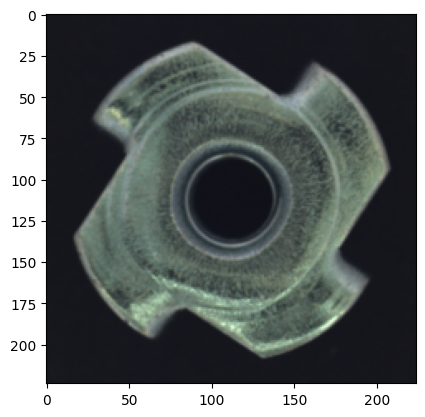

In [21]:
print(image.shape)
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.show()

# Memory

In [22]:
memory_usage = image.numel() * image.element_size()
print(f"Memory usage: {memory_usage / (1024 ** 2):.2f} MB")
print(f'Memory for all 208 images: {memory_usage * 208 / (1024 ** 2):.2f} MB')

Memory usage: 0.57 MB
Memory for all 208 images: 119.44 MB


In [23]:
train_image_folder = ImageFolder(root="./data/metal_nut/train", transform=transforms)
x, y = train_image_folder[0]
print(f"Image shape: {x.shape}, Label: {y}")

Image shape: torch.Size([3, 224, 224]), Label: 0


In [24]:
train_dataset,val_dataset = torch.utils.data.random_split(train_image_folder, [0.8, 0.2])
print(f"Train dataset size: {len(train_dataset)}")

Train dataset size: 176


# Dataloading


In [25]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

image_batch, labels = next(iter(train_loader))
print(f"Batch image shape: {image_batch.shape}, Batch labels shape: {labels.shape}")

memory_usage_batch = image_batch.numel() * image_batch.element_size()
print(f"Memory usage for batch: {memory_usage_batch / (1024 ** 2):.2f} MB")

Batch image shape: torch.Size([16, 3, 224, 224]), Batch labels shape: torch.Size([16])
Memory usage for batch: 9.19 MB


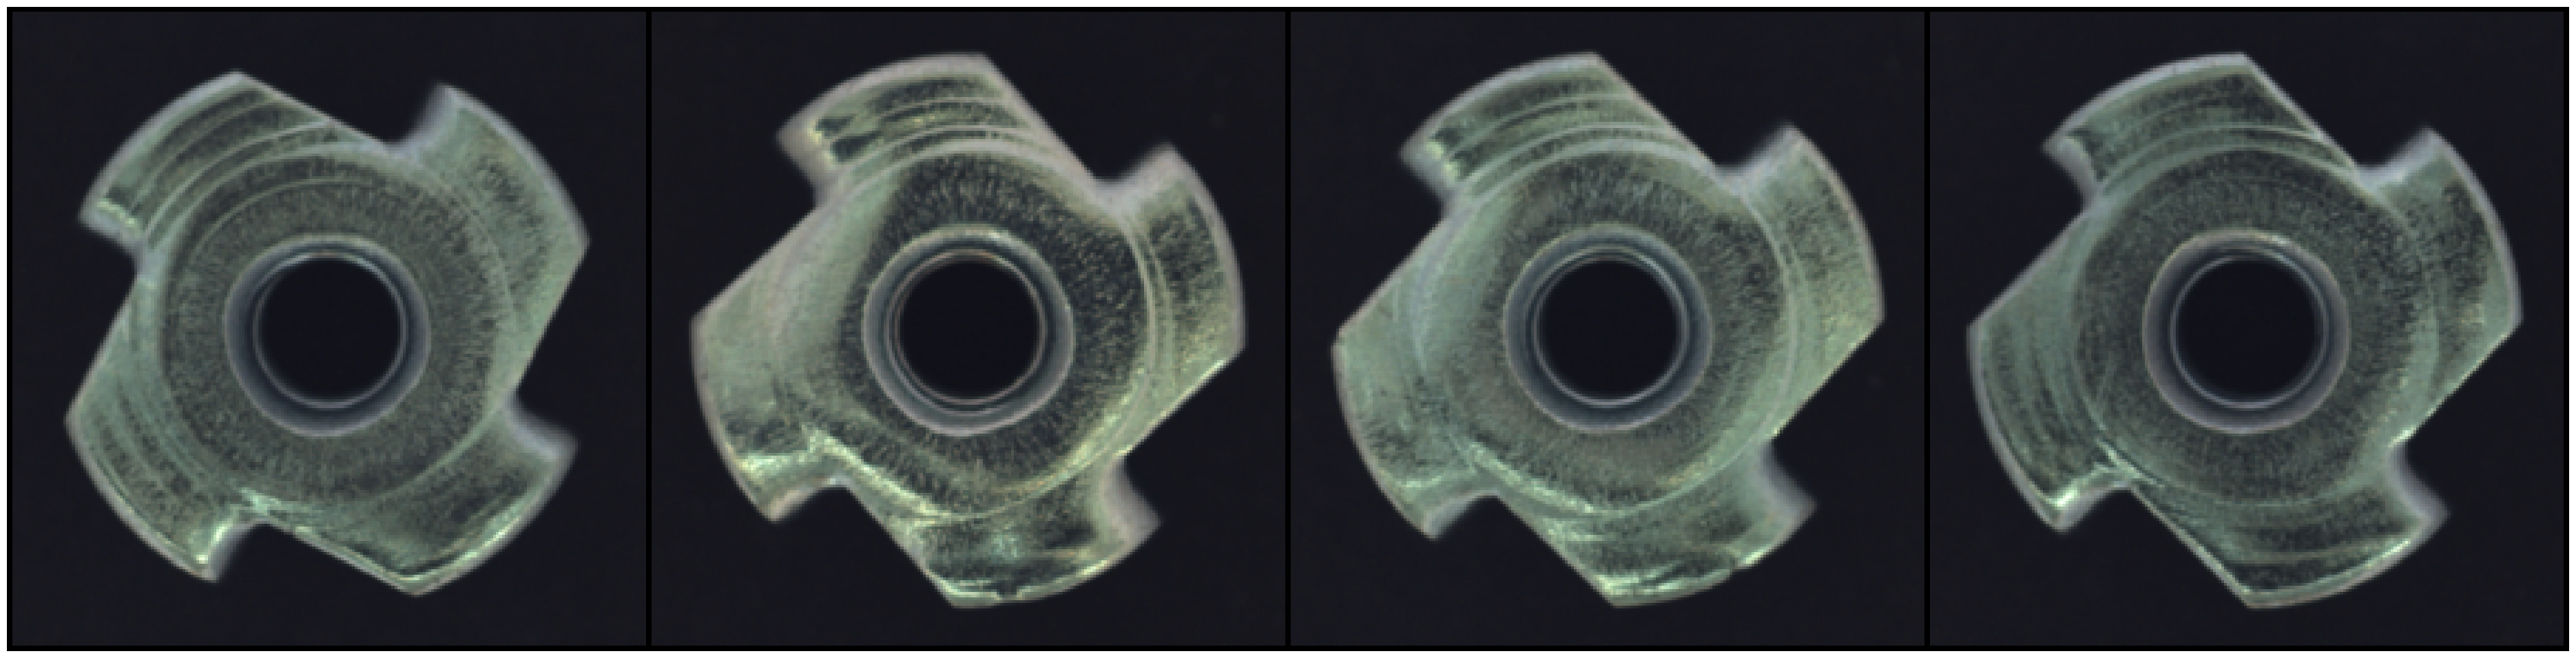

In [26]:
plt.figure(figsize=(12*4, 8*4))
grid_size = torchvision.utils.make_grid(image_batch[0:4], nrow=4)
plt.imshow(np.transpose(grid_size.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [27]:
input_image = Image.open(r'.\data\metal_nut\train\good\000.png')
input_image = transforms(input_image) 

input_image = input_image.unsqueeze(0) 

c1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4)
x = c1(input_image)
print(x.shape)
ap1 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap1(x)
print(x.shape)
c2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)
ap2 = nn.AvgPool2d(kernel_size=2, stride=2 )
x= ap2(c2(x))
print(x.shape)
c3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3 )
ap3 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap3(c3(x))
print(x.shape)

c4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, output_padding=1 )
x = c4(x)
print(x.shape)
c5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, output_padding=1 )
x = c5(x)
print(x.shape)
c6 = nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=5, stride=2, output_padding=1 )
x = c6(x)
print(x.shape)

torch.Size([1, 128, 221, 221])
torch.Size([1, 128, 110, 110])
torch.Size([1, 256, 53, 53])
torch.Size([1, 256, 25, 25])
torch.Size([1, 256, 53, 53])
torch.Size([1, 128, 110, 110])
torch.Size([1, 3, 224, 224])


In [28]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, output_padding=1 ),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()  
input_image = torch.randn(1, 3, 224, 224) 
output_image = model(input_image)
print(output_image.shape)  

torch.Size([1, 3, 224, 224])


In [29]:
ckpoints = torch.load('simple_autoencoder_l2_loss.pth')
model.load_state_dict(ckpoints)

model.cuda()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

  1%|          | 1/100 [00:09<15:45,  9.56s/it]

Epoch [1/100], Loss: 0.0383, Validation Loss: 0.0334


  6%|▌         | 6/100 [00:35<08:27,  5.40s/it]

Epoch [6/100], Loss: 0.0170, Validation Loss: 0.0173


 11%|█         | 11/100 [01:02<07:54,  5.33s/it]

Epoch [11/100], Loss: 0.0165, Validation Loss: 0.0164


 16%|█▌        | 16/100 [01:34<08:55,  6.38s/it]

Epoch [16/100], Loss: 0.0154, Validation Loss: 0.0154


 21%|██        | 21/100 [01:52<05:12,  3.95s/it]

Epoch [21/100], Loss: 0.0149, Validation Loss: 0.0148


 26%|██▌       | 26/100 [02:09<04:17,  3.48s/it]

Epoch [26/100], Loss: 0.0156, Validation Loss: 0.0149


 31%|███       | 31/100 [02:26<03:55,  3.41s/it]

Epoch [31/100], Loss: 0.0147, Validation Loss: 0.0142


 36%|███▌      | 36/100 [02:43<03:37,  3.40s/it]

Epoch [36/100], Loss: 0.0143, Validation Loss: 0.0141


 41%|████      | 41/100 [03:00<03:20,  3.39s/it]

Epoch [41/100], Loss: 0.0140, Validation Loss: 0.0140


 46%|████▌     | 46/100 [03:17<03:03,  3.39s/it]

Epoch [46/100], Loss: 0.0139, Validation Loss: 0.0136


 51%|█████     | 51/100 [03:34<02:46,  3.39s/it]

Epoch [51/100], Loss: 0.0145, Validation Loss: 0.0139


 56%|█████▌    | 56/100 [03:51<02:30,  3.42s/it]

Epoch [56/100], Loss: 0.0134, Validation Loss: 0.0134


 61%|██████    | 61/100 [04:08<02:13,  3.42s/it]

Epoch [61/100], Loss: 0.0137, Validation Loss: 0.0135


 66%|██████▌   | 66/100 [04:32<02:35,  4.56s/it]

Epoch [66/100], Loss: 0.0133, Validation Loss: 0.0130


 71%|███████   | 71/100 [04:52<01:51,  3.86s/it]

Epoch [71/100], Loss: 0.0134, Validation Loss: 0.0129


 76%|███████▌  | 76/100 [05:09<01:23,  3.48s/it]

Epoch [76/100], Loss: 0.0131, Validation Loss: 0.0128


 81%|████████  | 81/100 [05:26<01:05,  3.46s/it]

Epoch [81/100], Loss: 0.0124, Validation Loss: 0.0128


 86%|████████▌ | 86/100 [05:43<00:47,  3.41s/it]

Epoch [86/100], Loss: 0.0131, Validation Loss: 0.0130


 91%|█████████ | 91/100 [06:00<00:30,  3.39s/it]

Epoch [91/100], Loss: 0.0134, Validation Loss: 0.0129


 96%|█████████▌| 96/100 [06:17<00:13,  3.40s/it]

Epoch [96/100], Loss: 0.0124, Validation Loss: 0.0127


100%|██████████| 100/100 [06:31<00:00,  3.91s/it]


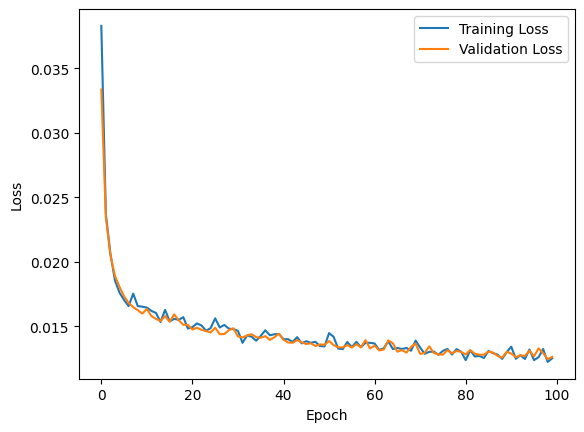

In [30]:



from tqdm import tqdm
Loss = []
Validation_Loss = []


num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()  
    for img, _ in train_loader:
        img = img.cuda()
        
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
    Loss.append(loss.item())
           
    model.eval()  
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for img, _ in val_loader:
            img = img.cuda()
            output = model(img)
            val_loss = criterion(output, img)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)
    
    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:


torch.save(model.state_dict(), 'simple_autoencoder_l1_loss_metal_nut.pth')
model.eval()

ckpoints = torch.load('simple_autoencoder_l1_loss_metal_nut.pth')
model.load_state_dict(ckpoints)

<All keys matched successfully>

torch.Size([16, 224, 224])


<Figure size 1600x1200 with 0 Axes>

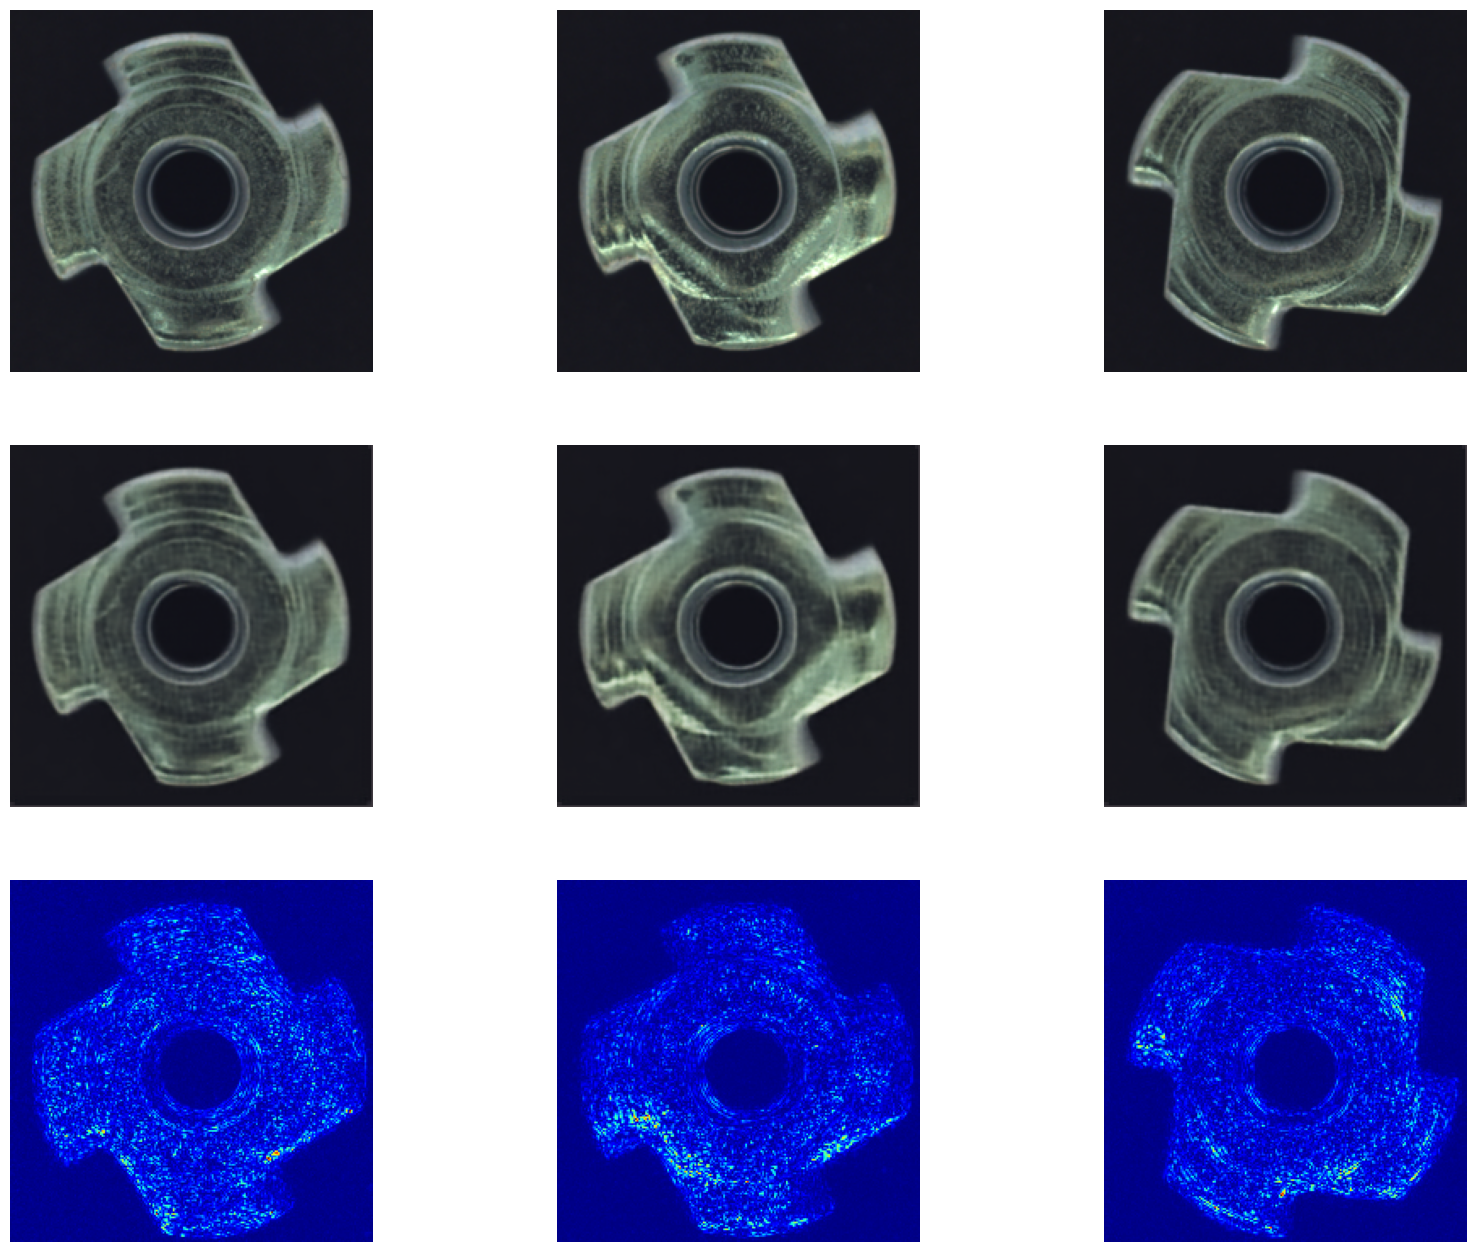

In [36]:
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        break

recon_error =  ((data-recon).abs()).mean(axis=1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i])) #[0:-10,0:-10]
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()

<Figure size 1600x1200 with 0 Axes>

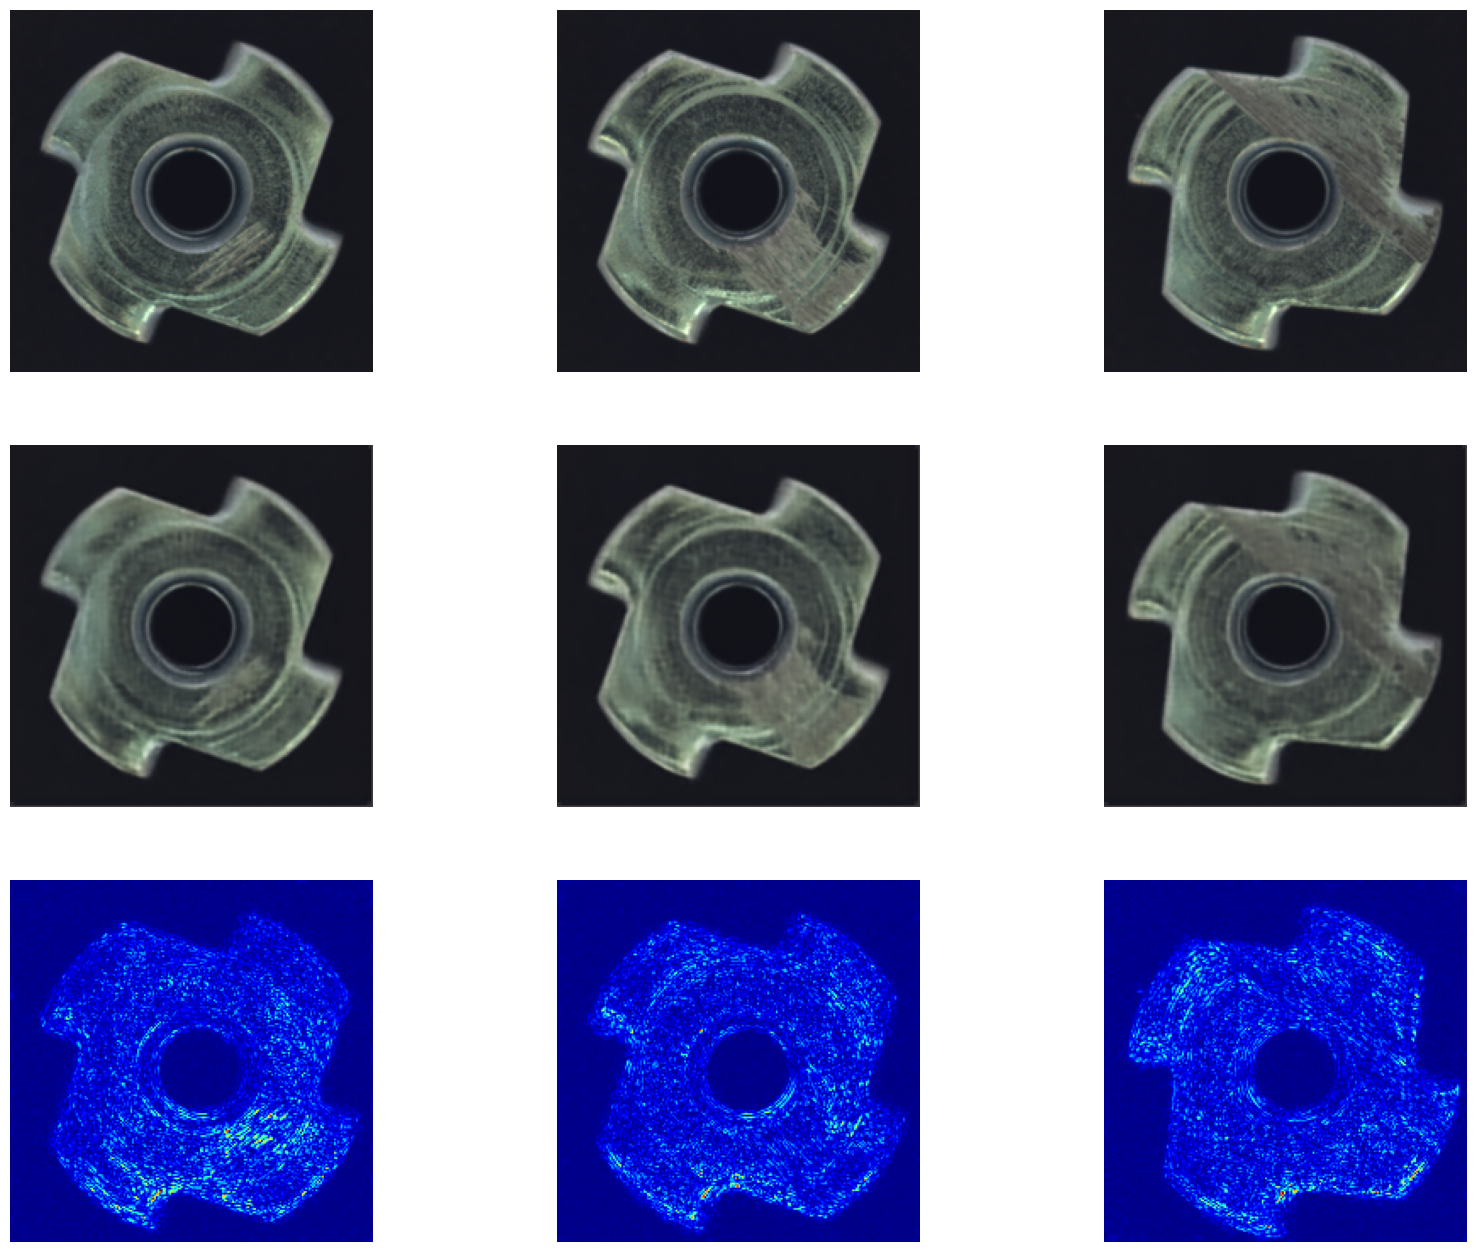

In [37]:
test_image_1 = transforms(Image.open(r'data\metal_nut\test\scratch\000.png'))
test_image_2 = transforms(Image.open(r'data\metal_nut\test\scratch\001.png'))
test_image_3 = transforms(Image.open(r'data\metal_nut\test\scratch\002.png'))

data = torch.stack([test_image_1,test_image_2, test_image_3])

with torch.no_grad():
    data = data.cuda()
    recon = model(data)
    
recon_error =  ((data-recon).abs()).mean(axis=1)
    
plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i]))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()

In [34]:
import os, json, math
from statistics import mean, pstdev

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("models", exist_ok=True)

# Reuse your Autoencoder class definition above.

def get_transforms():
    # Keep consistent with your training preprocessing
    return transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

def build_dataloaders(category, batch_size=16):
    tfm = get_transforms()
    # MVTec train contains only 'good'
    root = os.path.join(".", "data", category, "train")
    ds = ImageFolder(root=root, transform=tfm)
    n = len(ds)
    n_train = max(1, int(0.8 * n))
    n_val = n - n_train
    train_ds, val_ds = random_split(ds, [n_train, n_val])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, val_loader

@torch.no_grad()
def collect_recon_errors(model, loader):
    model.eval()
    errs = []
    for imgs, _ in loader:
        imgs = imgs.to(device)
        recon = model(imgs)
        err = ((imgs - recon) ** 2).mean(dim=(1,2,3))  # per-image scalar MSE
        errs.extend(err.detach().cpu().tolist())
    return errs

def train_one_category(category, epochs=50, lr=1e-3, weight_decay=0.0):
    train_loader, val_loader = build_dataloaders(category)
    model = Autoencoder().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()

    best_val = math.inf
    best_state = None

    for epoch in range(epochs):
        model.train()
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            out = model(imgs)
            loss = criterion(out, imgs)
            opt.zero_grad()
            loss.backward()
            opt.step()

        # simple validation average loss
        model.eval()
        val_loss_sum, val_batches = 0.0, 0
        with torch.no_grad():
            for imgs, _ in val_loader:
                imgs = imgs.to(device)
                out = model(imgs)
                vloss = criterion(out, imgs).item()
                val_loss_sum += vloss
                val_batches += 1
        val_loss = val_loss_sum / max(1, val_batches)

        if val_loss < best_val:
            best_val = val_loss
            best_state = {
                "model_state": model.state_dict(),
                "epoch": epoch + 1,
                "val_loss": best_val,
                "image_size": (224, 224),
                "category": category,
            }

        if (epoch + 1) % 5 == 0:
            print(f"[{category}] Epoch {epoch+1}/{epochs} val_loss={val_loss:.6f}")

    # Load best state, compute calibration on full val set
    model.load_state_dict(best_state["model_state"])
    val_errors = collect_recon_errors(model, val_loader)
    if len(val_errors) == 0:
        # fallback if no val split (tiny dataset)
        val_errors = [best_val]

    mu = float(mean(val_errors))
    sigma = float(pstdev(val_errors) if len(val_errors) > 1 else 1e-6)
    p95 = float(np.percentile(val_errors, 95)) if len(val_errors) > 1 else mu

    best_state["calibration"] = {"mean": mu, "std": sigma, "p95": p95}

    # save checkpoint
    save_path = os.path.join("models", f"{category}_autoencoder_best.pt")
    torch.save(best_state, save_path)
    print(f"[{category}] Saved {save_path} (val_loss={best_val:.6f}, p95={p95:.6f})")

    return save_path